In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
import requests
import datetime
from datetime import datetime, timedelta
import seaborn as sns

In [2]:
tickers = ['TSLA','AAPL','MSFT','DELL','NVDA']

In [3]:
end_date = datetime.today()
start_date = end_date - timedelta(days = 5*365)

In [4]:
adj_close = pd.DataFrame()

In [5]:
for ticker in tickers:
    data = yf.download(ticker, start=start_date, end=end_date)
    adj_close[ticker] = data['Adj Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


Получаем значения Adj Close за последние 5 лет

In [6]:
adj_close

,TSLA,AAPL,MSFT,DELL,NVDA
Date,,,,,
2019-05-20,13.690667,44.174911,120.375488,32.396049,37.679852
2019-05-21,13.672000,45.021786,121.023979,33.182125,38.501732
2019-05-22,12.848667,44.100117,121.758339,32.872456,37.791580
2019-05-23,13.032667,43.347343,120.337334,31.300301,36.579868
2019-05-24,12.708667,43.180866,120.394531,31.500385,36.041050
...,...,...,...,...,...
2024-05-09,171.970001,184.320007,411.577637,131.679993,887.469971
2024-05-10,168.470001,183.050003,413.993256,132.770004,898.780029
2024-05-13,171.889999,186.279999,412.975098,131.009995,903.989990


<Axes: xlabel='Date'>

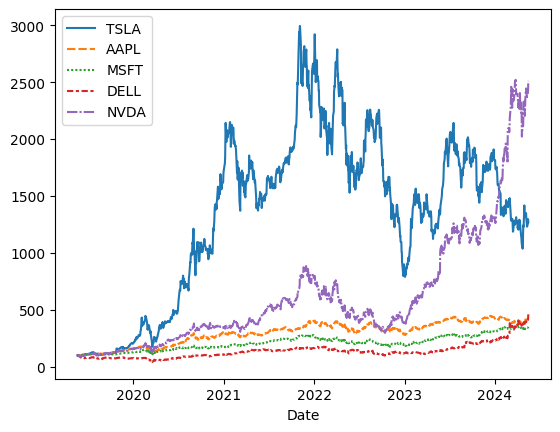

In [7]:
sns.lineplot(adj_close * 100 / adj_close.iloc[0])

<Axes: xlabel='Date'>

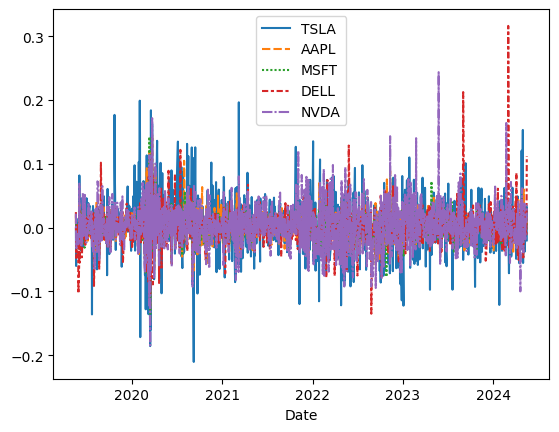

In [8]:
sns.lineplot(adj_close.pct_change())

Посчитаем дневную доходность акций.

In [9]:
# Дневная доходность
daily_pct_change = adj_close.pct_change()

daily_pct_change.fillna(0, inplace=True)

print(daily_pct_change.head())

# Дневная лог доходность
daily_log_returns = np.log(adj_close.pct_change()+1)

print(daily_log_returns.head())

                TSLA      AAPL      MSFT      DELL      NVDA
Date                                                        
2019-05-20  0.000000  0.000000  0.000000  0.000000  0.000000
2019-05-21 -0.001363  0.019171  0.005387  0.024265  0.021812
2019-05-22 -0.060220 -0.020472  0.006068 -0.009332 -0.018445
2019-05-23  0.014321 -0.017070 -0.011671 -0.047826 -0.032063
2019-05-24 -0.024861 -0.003841  0.000475  0.006392 -0.014730
                TSLA      AAPL      MSFT      DELL      NVDA
Date                                                        
2019-05-20       NaN       NaN       NaN       NaN       NaN
2019-05-21 -0.001364  0.018989  0.005373  0.023975  0.021578
2019-05-22 -0.062110 -0.020684  0.006050 -0.009376 -0.018617
2019-05-23  0.014219 -0.017217 -0.011739 -0.049007 -0.032588
2019-05-24 -0.025175 -0.003848  0.000475  0.006372 -0.014839


### Построим оптимизацию портфеля по Марковицу

<Axes: >

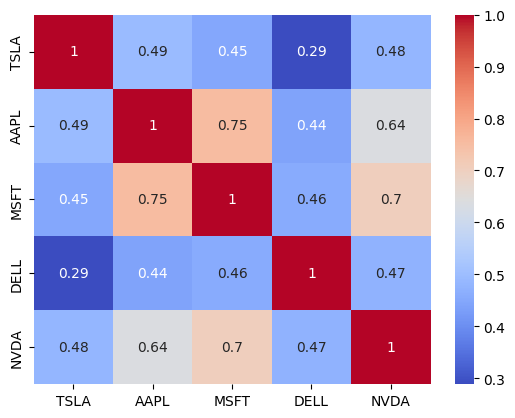

In [10]:
corr_data = adj_close.pct_change().corr(method='pearson')
sns.heatmap(corr_data, annot=True, cmap='coolwarm')

In [11]:
daily_log_returns = daily_log_returns.dropna()

Создаем пустые массивы

In [12]:
ret_arr = np.zeros(5000)
vol_arr = np.zeros(5000)
sr_arr = np.zeros(5000)
wt_arr = np.zeros((5000, len(adj_close.columns)))

In [13]:
for i in range(5000):
    w = np.random.random(len(adj_close.columns))
    w = w/np.sum(w)
    wt_arr[i, :] = w
    ret_arr[i] = np.sum(daily_log_returns.mean() * 252 * w)
    vol_arr[i] = np.sqrt(np.dot(w.T, np.dot(daily_log_returns.cov() * 252, w)))
    sr_arr[i] = ret_arr[i]/vol_arr[i]

In [14]:
res = sr_arr.max()

In [15]:
daily_log_returns.cov()

,TSLA,AAPL,MSFT,DELL,NVDA
TSLA,0.001680,0.000410,0.000359,0.000320,0.000657
AAPL,0.000410,0.000399,0.000290,0.000236,0.000422
MSFT,0.000359,0.000290,0.000367,0.000234,0.000444
DELL,0.000320,0.000236,0.000234,0.000684,0.000414
NVDA,0.000657,0.000422,0.000444,0.000414,0.001064


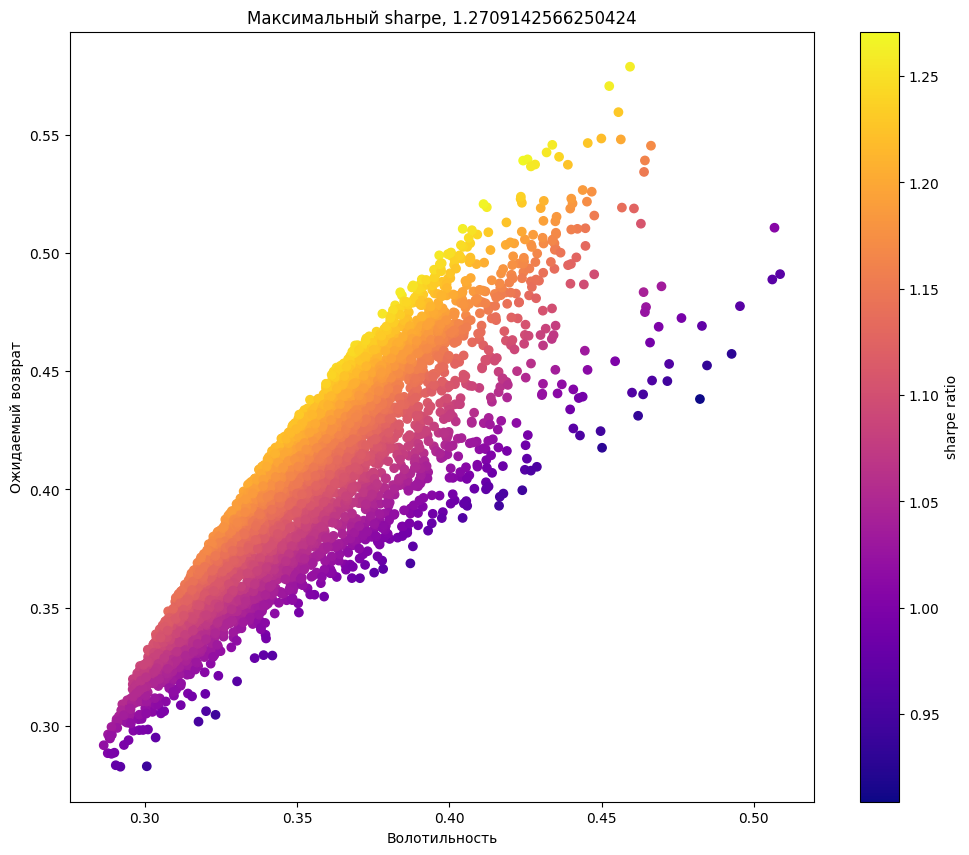

In [16]:
plt.figure(figsize=(12,10))
plt.scatter(vol_arr, ret_arr, c=sr_arr, cmap='plasma')
plt.colorbar(label='sharpe ratio')
plt.xlabel('Волотильность')
plt.ylabel('Ожидаемый возврат')
plt.title('Максимальный sharpe, '+str(res))
plt.show()

In [43]:
# Определение портфеля с максимальным коэффициентом Шарпа
max_sr_idx = np.argmax(sr_arr)
max_sr_ret = ret_arr[max_sr_idx]
max_sr_vol = vol_arr[max_sr_idx]
optimal_weights = wt_arr[max_sr_idx]

# Вывод результатов
stocks = adj_close.columns
for weight, stock in zip(optimal_weights, stocks):
    print(f'{round(weight * 100, 2)}% акции {stock} Нужно преобрести.')

print(f'\nОптимальная доходность по Марковицу составляет: {round(max_sr_ret * 100, 2)}% при волотильности {round(max_sr_vol * 100, 2)}%')

10.62% акции TSLA Нужно преобрести.
8.35% акции AAPL Нужно преобрести.
0.6% акции MSFT Нужно преобрести.
17.94% акции DELL Нужно преобрести.
62.48% акции NVDA Нужно преобрести.

Оптимальная доходность по Марковицу составляет: 53.92% при волотильности 42.42%


### Метод Монте-Карло

In [19]:
def expected_return(weights, log_returns):
    return np.sum(log_returns.mean()*weights)

def standart_deviation(weights, cov_matrix):
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)



In [17]:
daily_log_returns.cov()

,TSLA,AAPL,MSFT,DELL,NVDA
TSLA,0.001680,0.000410,0.000359,0.000320,0.000657
AAPL,0.000410,0.000399,0.000290,0.000236,0.000422
MSFT,0.000359,0.000290,0.000367,0.000234,0.000444
DELL,0.000320,0.000236,0.000234,0.000684,0.000414
NVDA,0.000657,0.000422,0.000444,0.000414,0.001064


Предположим что наш портфель стоит 10000$

In [20]:
portfolio_value = 10000
weights = np.array([1/len(tickers)]*len(tickers))
portfolio_expected_return = expected_return(weights, daily_log_returns)
portfolio_standart_deviation = standart_deviation(weights, daily_log_returns.cov())

In [21]:
def random_z_score():
    return np.random.normal(0,1)

Создаем функцию подсчета прибыли убытка

In [22]:
days = 20
def scenario_gain_loss(portfolio_value, portfolio_std_dev, z_score, days):
    return portfolio_value * portfolio_expected_return * days + portfolio_value * portfolio_std_dev * z_score * np.sqrt(days)

In [23]:
iterations = 10000
scenario_returns = []

for i in range (iterations):
    z_score = random_z_score()
    scenario_returns.append(scenario_gain_loss(portfolio_value, portfolio_standart_deviation, z_score, days))
    
    

Создание доверительного интервала

In [25]:
confidence_interval = 0.95 

In [26]:
var = -np.percentile(scenario_returns, 100*(1-confidence_interval))

In [27]:
var

1244.2274395419752

Рискованная ценость равняется 1244 на 20 дней по доверительному интервалу 95%

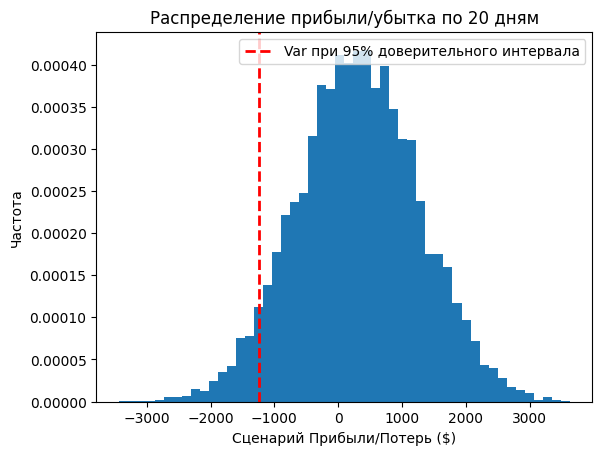

In [34]:
plt.hist(scenario_returns, bins=50, density=True)
plt.xlabel('Сценарий Прибыли/Потерь ($)')
plt.ylabel('Частота')
plt.title(f'Распределение прибыли/убытка по {days} дням')
plt.axvline(-var, color='r', linestyle='dashed', linewidth=2, label=f'Var при {confidence_interval:.0%} доверительного интервала')
plt.legend()
plt.show()

Запустим симуляцию Монте-Карло

In [36]:
num_simulations = 5000
num_days = 252   

weights = np.array(w/100).T
results = np.zeros((num_simulations, num_days))

for i in range(num_simulations):
    daily_returns = np.random.multivariate_normal(np.array(daily_log_returns.mean()).flatten(), np.array(daily_log_returns.cov()), 252)
    results[i, :] = np.cumsum(np.dot(weights, daily_returns.T))

results_frame = pd.DataFrame(results)

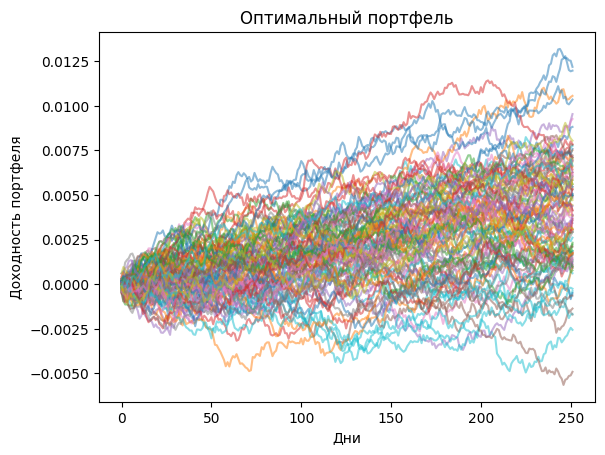

In [37]:
for i in range(100):
    plt.plot(results_frame.loc[i, :], alpha=0.5)

plt.xlabel('Дни')
plt.ylabel('Доходность портфеля')
plt.title("Оптимальный портфель")
plt.show()